# Модель предсказания срывов поставок на основе LightGBM

## Библиотеки и модули

Загрузка библиотек и модулей, используемых при решении. 
- Модель: **LGBMClassifier** из библиотеки **LightGBM**
- Предобработчик данных для модели: **DataPreprocessor** (из модуля **helper.data**)
- Борьба с дисбалансом классов: **RandomOverSampler** (библиотека **imbalanced-learn**)
- Разделение на тренировочную и тестовую выборки, кросс-валидация, оценка решения: 
    - библиотека **scikit-learn**
    - **valid_predictions** (из модуля **helpers.validation**)
- Работа с датасетом: библиотека **pandas** 
- Работа с файловой системой: модуль **os**

In [63]:
# Модель
import lightgbm 
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Пайплайн
from sklearn.pipeline import Pipeline
from helpers.data import DataPreprocessor
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import shap

# Настройки вывода
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Загрузка датасетов

In [66]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')
MODEL_SAVE_PATH = os.path.join(ROOT, '../output/lgbm_model.dat')

# Функции
def make_predictions(model: object | Pipeline, X_test: pd.DataFrame) -> Pipeline:
    """ Функция создания предсказаний для тестовой выборки.
    
    Обучает переданную модель на сбалансированном датасете, учитывая выбросы.
    Предсказания сохраняются с помощью функции save_submission.
    
    Параметры:
        model: Модель или пайплайн, используемый для обучения и предсказания меток
            тестовой выборки.
        X_test: Тестовая выборка, для которой будут сделаны предсказания.
            Экземпляр pandas.DataFrame.
            
    Возвращает пайплайн модели для инференса."""

    # Балансировка
    positive_entries = train_df[train_df['y'] == 1]
    negative_count = len(train_df[train_df['y'] == 0])
    positive_count = len(positive_entries)
    balanced_df = pd.concat([train_df, positive_entries])
    for _ in range(int(negative_count / positive_count) - 1):
        balanced_df = pd.concat([balanced_df, positive_entries])
    
    # Обрезка негативных записей до числа позитивных
    first_negatives = balanced_df[balanced_df['y'] == 0][:balanced_df[balanced_df['y'] == 1]['y'].count()]
    balanced_df = pd.concat([balanced_df[balanced_df['y'] == 1], first_negatives])

    # Удаление выбросов
    balanced_df = balanced_df[balanced_df['Длительность'] < 400]
    balanced_df = balanced_df[(balanced_df['Сумма'] > 2) & (balanced_df['Сумма'] < 10)]
    balanced_df = balanced_df[balanced_df['До поставки'] < 300]
    balanced_df = balanced_df[balanced_df['Дней между 0_1'] < 400]
    balanced_df = balanced_df[balanced_df['Количество изменений после согласований'] < 2000]
    balanced_df = balanced_df[balanced_df['Количество'] < 300000]
    
    # Разделение независимых и независимых переменных
    X, y = balanced_df.iloc[:, :-1], balanced_df.iloc[:, -1]   

    # Обучение модели и создание предсказаний для тестовой выборки
    model.fit(X, y)
    preds = model.predict(X_test)

    # Сохранение предсказаний
    save_submission(preds, 'submission')
    return model
    
def save_submission(preds: list | pd.DataFrame | pd.arrays.PandasArray, subname: str) -> None:
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)


# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

# Удаление дубликатов из тренировочной выборки
# train_df = train_df.drop_duplicates()

# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Удаление выбросов из тренировочной выборки
X_train = pd.concat([X_train, y_train], axis=1) # Объединяем X_train и y_train
X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

# Отделяем метки классов от признаков
y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

# Общий датасет для большего числа записей, используемых на кросс-валидации
X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

## Тестирование модели

### Создание пайплайна

- Кросс-валидация: используется X_general и y_general, не содержащие дубликатов.
- Валидация на тестовой выборке (X_test, y_test): используется X_res и y_res, полученные с помощью рандомного оверсемплирования X_train и y_train.
- Модель: LGBMClassifier из библиотеки LightGBM
- Параметры модели: подобраны с учётом результатов подбора гиперпараметров, а также ручных корректировок для повышения обобщающей способности.
- Пайплайн:
    - Предобработчик: кастомный предобработчик DataPreproccessor из модуля helper.data, совмещающий BinaryEncoder, RobustScaler, экстракцию признаков.
    - Модель: LGBMClassifier

In [67]:
# Создание оверсемпл-датасета (отбор рандомных записей)
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)

# Параметры модели
parameters = {
    'objective': 'binary',
    'force_col_wise': True,
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 256, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Предобработчик и модель
data_preprocessor = DataPreprocessor()
model = LGBMClassifier(**parameters, n_jobs=-1)

# Пайплайн
pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

### Кросс-валидация
- Для кросс-валидации используется алгоритм Stratified K-Fold, учитывающий распределение классов. 
- Число используемых фолдов: 5.
- Метрика: F1-macro

In [ ]:
# Запуск кросс-валидации
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
print(f'Mean F1-macro: {cv_scores.mean()}')

### Валидация на тестовой выборке

In [69]:
# Обучение модели и получение предсказаний для тестовой выборки
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[LightGBM] [Info] Number of positive: 29000, number of negative: 172903
[LightGBM] [Info] Total Bins 3164
[LightGBM] [Info] Number of data points in the train set: 201903, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143633 -> initscore=-1.785435
[LightGBM] [Info] Start training from score -1.785435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


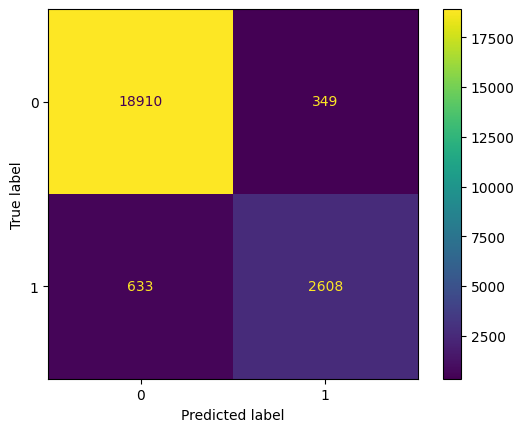

              precision    recall  f1-score   support

           0    0.96761   0.98188   0.97469     19259
           1    0.88197   0.80469   0.84156      3241

    accuracy                        0.95636     22500
   macro avg    0.92479   0.89328   0.90813     22500
weighted avg    0.95527   0.95636   0.95552     22500

F1-macro: 0.9081269101556775
ROC-AUC score: 0.8932842563666985
Accuracy: 0.9563555555555555


In [70]:
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)

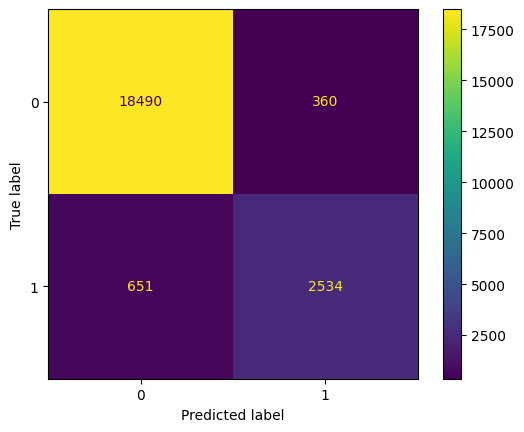

              precision    recall  f1-score   support

           0    0.96599   0.98090   0.97339     18850
           1    0.87560   0.79560   0.83369      3185

    accuracy                        0.95412     22035
   macro avg    0.92080   0.88825   0.90354     22035
weighted avg    0.95292   0.95412   0.95320     22035

F1-macro: 0.903539092853348
ROC-AUC score: 0.8882531261841605
Accuracy: 0.9541184479237577


In [ ]:
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)

### Интерпретация модели

Для интерпретации модели можно: 
- Построить график важности признаков.
- Построить график SHAP

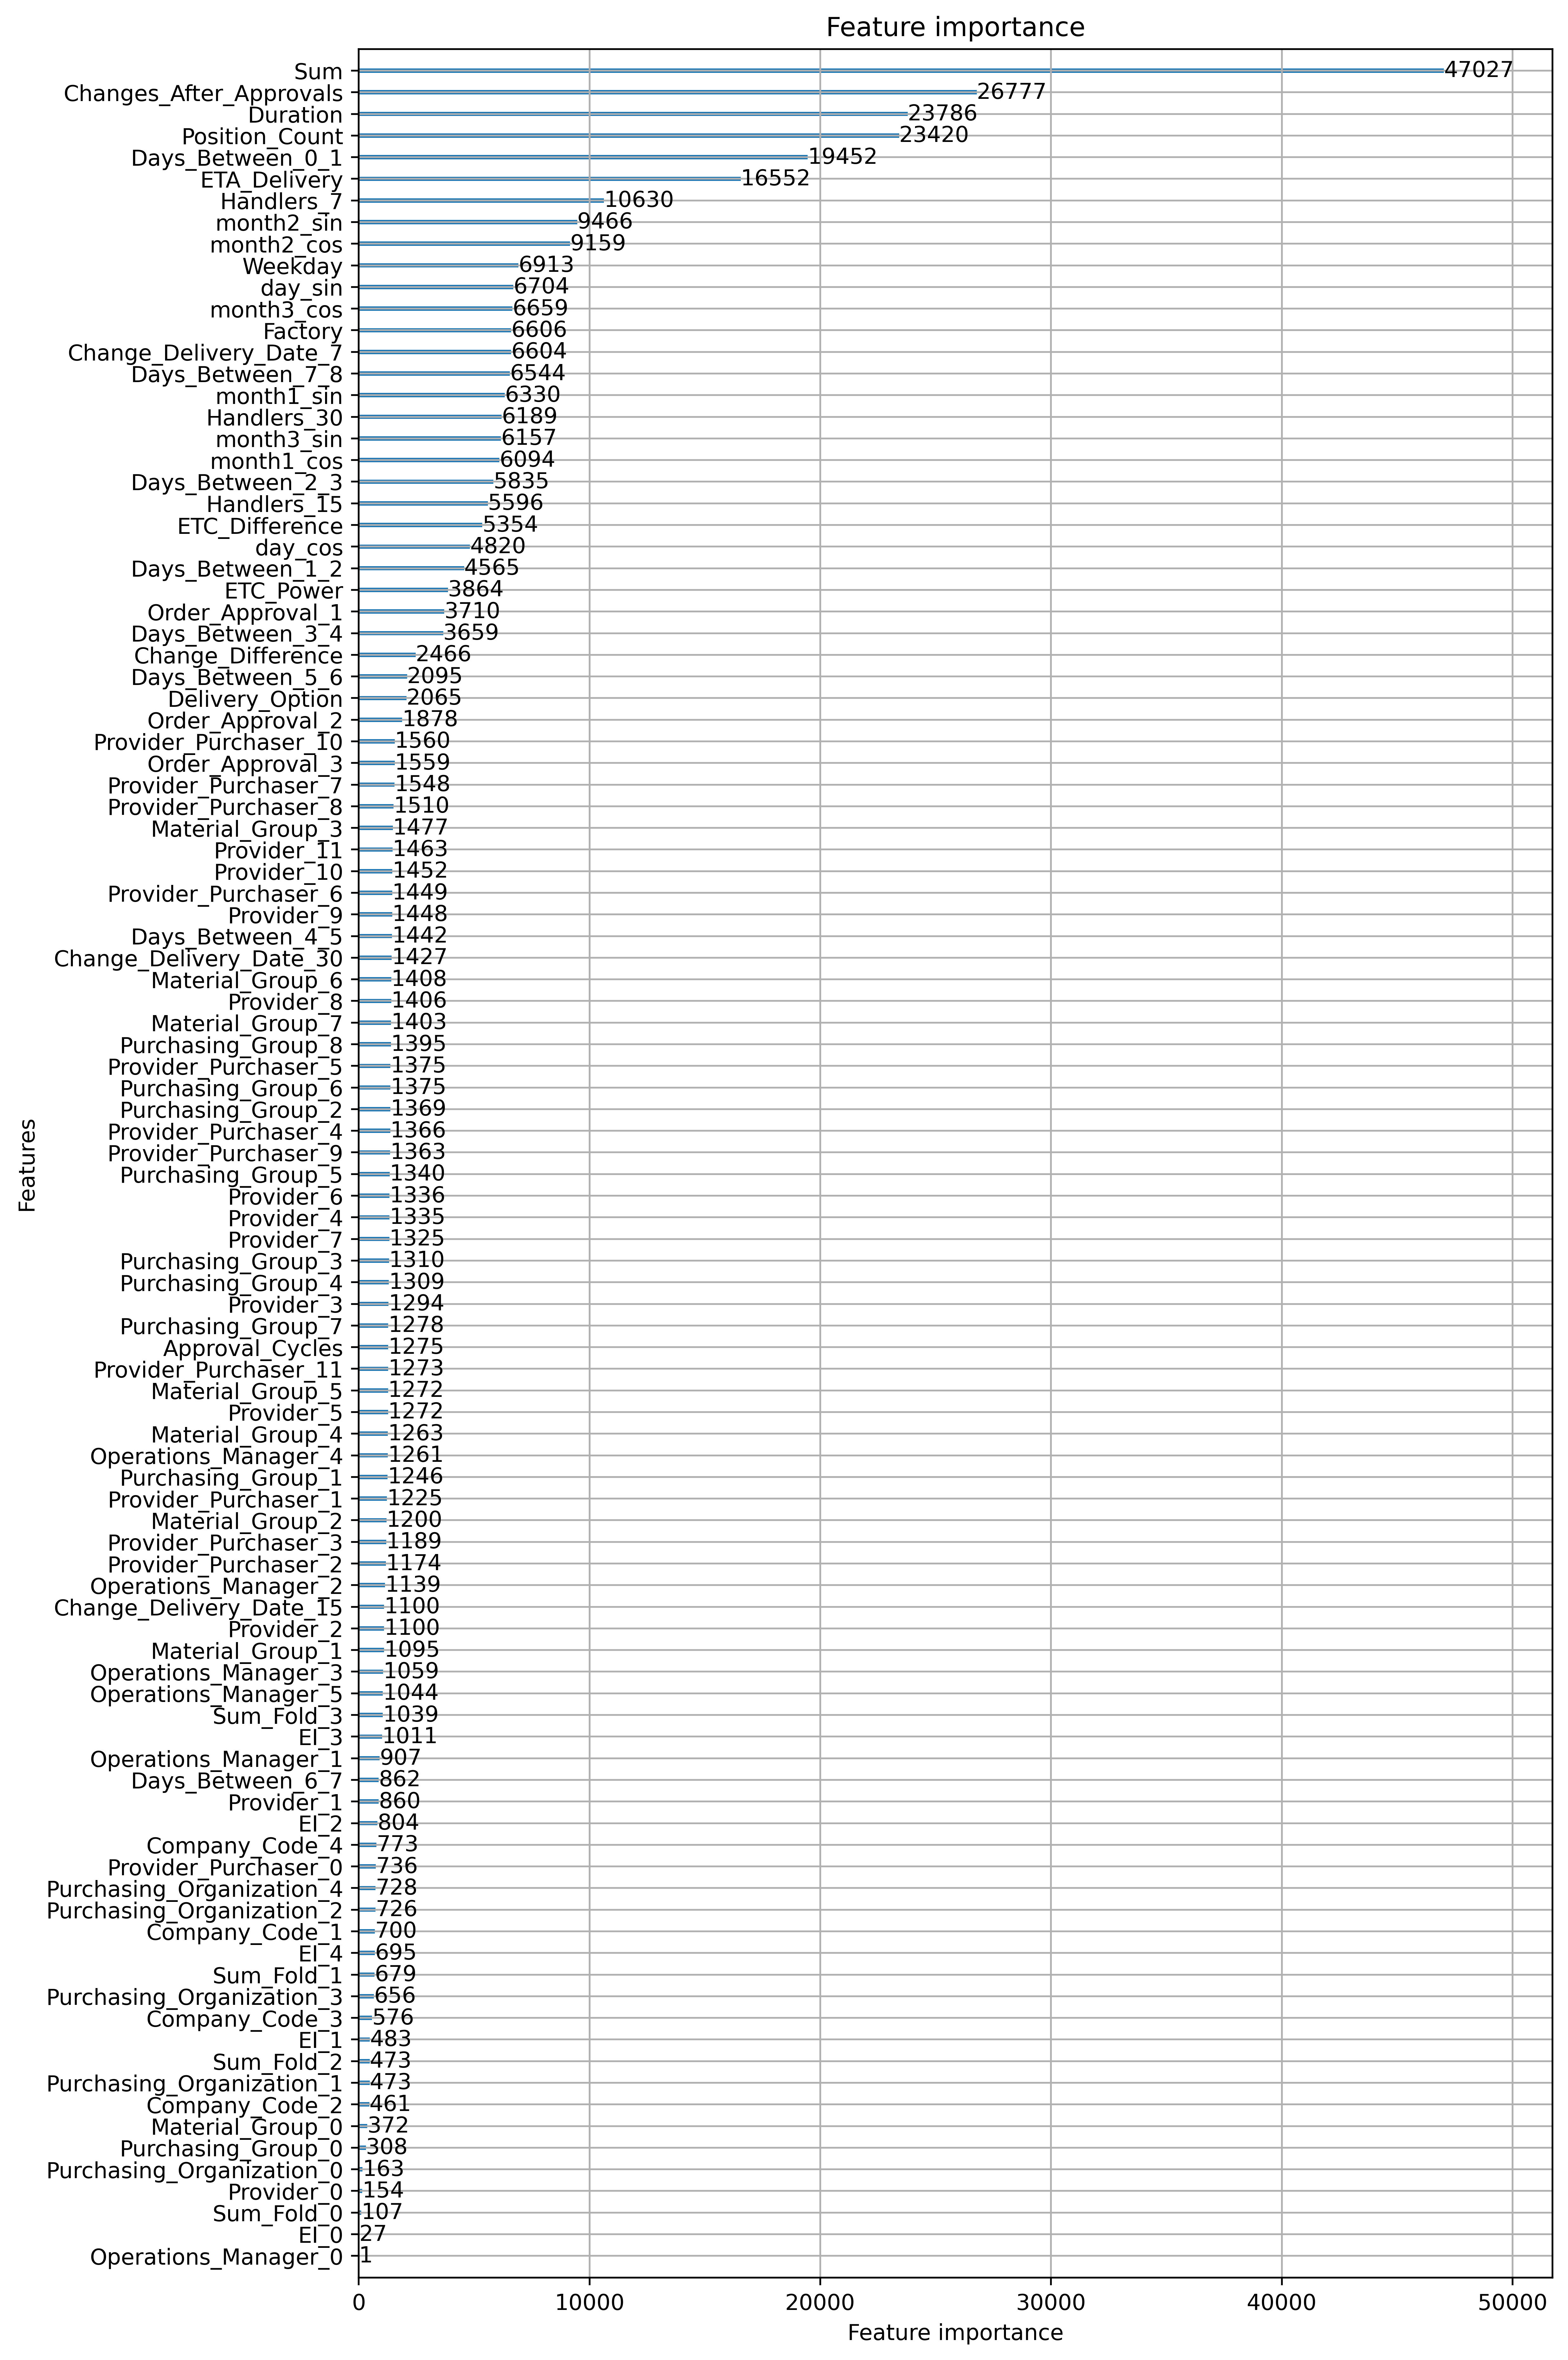

In [8]:
# Построение 
lightgbm.plot_importance(pipeline['model'], figsize=(10, 15), dpi=500)
plt.tight_layout()
plt.show()

In [7]:
random_true = pd.DataFrame([X_test[(y_test == 1) & (X_test['Количество изменений после согласований'] < 10)].iloc[1]])

In [11]:
data_preprocessor_shap = DataPreprocessor()
data_preprocessor_shap.fit(X_train, y_train)
X_test_shap = data_preprocessor_shap.transform(X_test)

In [14]:
# Сохраняем дамп модели для инференса
import pickle
with open('../output/lgbm_preprocessor.dat', 'wb+') as file:
    pickle.dump(data_preprocessor_shap, file)

In [9]:
random_true_pred = pipeline.predict(random_true)
random_true_pred

array([1], dtype=int64)

In [10]:
random_true

Поставщик  Материал  Категорийный менеджер  Операционный менеджер  \
204764      154.0   23778.0                    1.0                   11.0   

        Завод  Закупочная организация  Группа закупок  Балансовая единица  \
204764    5.0                     4.0            45.0                 4.0   

         ЕИ  Группа материалов  ...  Количество циклов согласования  \
204764  4.0               37.0  ...                             0.0   

        Количество изменений после согласований  Дней между 0_1  \
204764                                      8.0             0.0   

        Дней между 1_2  Дней между 2_3  Дней между 3_4  Дней между 4_5  \
204764             5.0            -1.0            -1.0            -1.0   

        Дней между 5_6  Дней между 6_7  Дней между 7_8  
204764            -1.0            -1.0            -1.0  

[1 rows x 43 columns]

In [12]:
data_preprocessor_shap.transform(random_true)

Provider_0  Provider_1  Provider_2  Provider_3  Provider_4  \
204764           0           0           0           0           1   

        Provider_5  Provider_6  Provider_7  Provider_8  Provider_9  ...  \
204764           0           0           0           1           0  ...   

        Change_Difference  ETC_Power   day_sin   day_cos    month1_sin  \
204764                0.0  -0.166667 -0.974928 -0.222521 -2.449294e-16   

        month1_cos  month2_sin  month2_cos    month3_sin  month3_cos  
204764         1.0    0.866025         0.5 -2.449294e-16         1.0  

[1 rows x 103 columns]

In [16]:
df_prec

Provider_0  Provider_1  Provider_2  Provider_3  Provider_4  Provider_5  \
6868            0           0           0           0           0           0   
24016           0           0           0           1           1           0   
9668            0           0           0           0           0           0   
13640           0           0           0           0           0           0   
14018           0           0           0           0           1           1   
...           ...         ...         ...         ...         ...         ...   
1747            0           0           1           0           0           0   
323             0           0           0           1           0           1   
10296           0           0           0           1           0           0   
12750           0           0           0           0           0           0   
10012           0           0           0           0           0           0   

       Provider_6  Provider_7  Provider_8  Provider_9  ...  Change_Difference  \
6868            0           0           0           1  ...                  0   
24016           0           0           1           1  ...                  0   
9668            0           0           0           1  ...                  0   
13640           0           0           0           1  ...                  0   
14018           1           0           1           0  ...                  0   
...           ...         ...         ...         ...  ...                ...   
1747            1           0           1           0  ...                  0   
323             0           1           1           1  ...                  0   
10296           0           1           0           0  ...                  0   
12750           0           0           0           0  ...                  0   
10012           0           0           0           1  ...                  0   

       ETC_Power       day_sin   day_cos    month1_sin  month1_cos  \
6868    0.166667  9.749279e-01 -0.222521 -8.660254e-01    0.500000   
24016   0.416667  7.818315e-01  0.623490 -8.660254e-01    0.500000   
9668    0.166667  4.338837e-01 -0.900969  1.224647e-16   -1.000000   
13640  -0.166667 -9.749279e-01 -0.222521 -2.449294e-16    1.000000   
14018  -0.166667 -9.749279e-01 -0.222521 -8.660254e-01    0.500000   
...          ...           ...       ...           ...         ...   
1747    0.083333 -4.338837e-01 -0.900969  8.660254e-01    0.500000   
323     1.166667 -2.449294e-16  1.000000  5.000000e-01    0.866025   
10296   2.916667 -4.338837e-01 -0.900969 -5.000000e-01   -0.866025   
12750  -0.166667  4.338837e-01 -0.900969 -8.660254e-01   -0.500000   
10012  -0.166667 -4.338837e-01 -0.900969 -5.000000e-01    0.866025   

         month2_sin    month2_cos    month3_sin    month3_cos  
6868  -2.449294e-16  1.000000e+00 -8.660254e-01  5.000000e-01  
24016 -2.449294e-16  1.000000e+00 -8.660254e-01  5.000000e-01  
9668  -5.000000e-01 -8.660254e-01  1.224647e-16 -1.000000e+00  
13640  5.000000e-01  8.660254e-01 -2.449294e-16  1.000000e+00  
14018 -5.000000e-01  8.660254e-01 -8.660254e-01  5.000000e-01  
...             ...           ...           ...           ...  
1747   8.660254e-01 -5.000000e-01  1.000000e+00  6.123234e-17  
323    1.000000e+00  6.123234e-17  5.000000e-01  8.660254e-01  
10296 -8.660254e-01  5.000000e-01 -8.660254e-01 -5.000000e-01  
12750 -1.000000e+00 -1.836970e-16 -8.660254e-01 -5.000000e-01  
10012  8.660254e-01  5.000000e-01 -5.000000e-01  8.660254e-01  

[200 rows x 103 columns]

In [ ]:
data = pd.DataFrame(test_df.sample(200, random_state=42))
df_prec = data_preprocessor_shap.transform(data)
explainer = shap.TreeExplainer(pipeline['model'], df_prec)

In [17]:
explanation = explainer(df_prec, check_additivity=False)

 99%|===================| 198/200 [00:43<00:00]        

In [ ]:
test_df

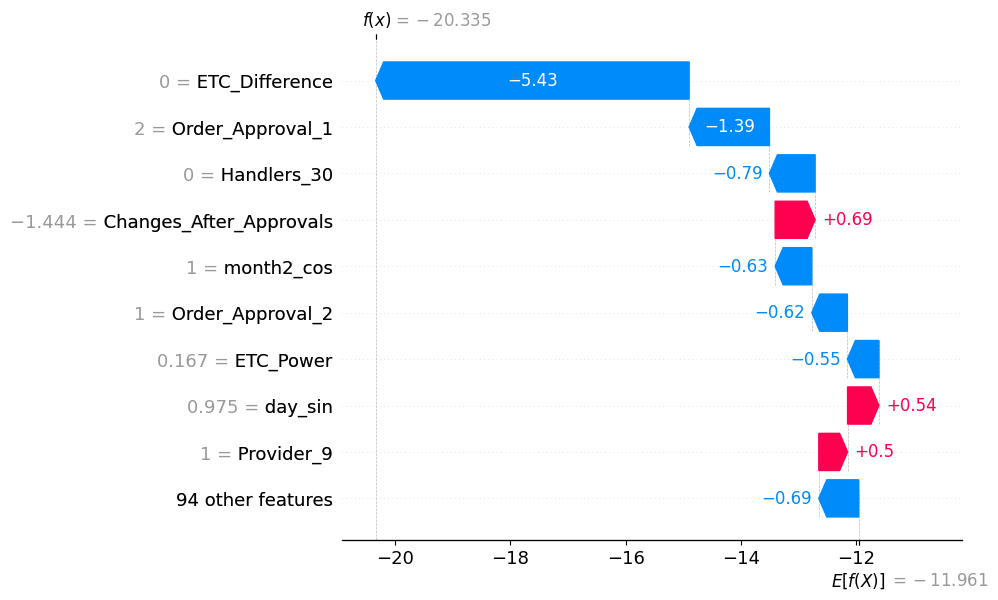

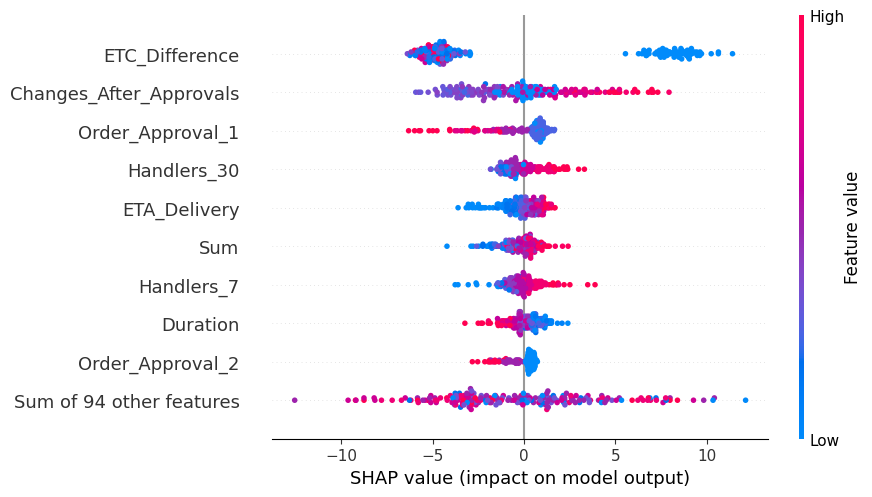

In [22]:
shap.initjs()
shap.plots.waterfall(shap_values[0])
shap.plots.beeswarm(shap_values)

In [26]:
shap_values = explainer.shap_values(df_prec, check_additivity=False)

100%|===================| 199/200 [00:43<00:00]        

In [28]:
df_prec

Provider_0  Provider_1  Provider_2  Provider_3  Provider_4  Provider_5  \
6868            0           0           0           0           0           0   
24016           0           0           0           1           1           0   
9668            0           0           0           0           0           0   
13640           0           0           0           0           0           0   
14018           0           0           0           0           1           1   
...           ...         ...         ...         ...         ...         ...   
1747            0           0           1           0           0           0   
323             0           0           0           1           0           1   
10296           0           0           0           1           0           0   
12750           0           0           0           0           0           0   
10012           0           0           0           0           0           0   

       Provider_6  Provider_7  Provider_8  Provider_9  ...  Change_Difference  \
6868            0           0           0           1  ...                  0   
24016           0           0           1           1  ...                  0   
9668            0           0           0           1  ...                  0   
13640           0           0           0           1  ...                  0   
14018           1           0           1           0  ...                  0   
...           ...         ...         ...         ...  ...                ...   
1747            1           0           1           0  ...                  0   
323             0           1           1           1  ...                  0   
10296           0           1           0           0  ...                  0   
12750           0           0           0           0  ...                  0   
10012           0           0           0           1  ...                  0   

       ETC_Power       day_sin   day_cos    month1_sin  month1_cos  \
6868    0.166667  9.749279e-01 -0.222521 -8.660254e-01    0.500000   
24016   0.416667  7.818315e-01  0.623490 -8.660254e-01    0.500000   
9668    0.166667  4.338837e-01 -0.900969  1.224647e-16   -1.000000   
13640  -0.166667 -9.749279e-01 -0.222521 -2.449294e-16    1.000000   
14018  -0.166667 -9.749279e-01 -0.222521 -8.660254e-01    0.500000   
...          ...           ...       ...           ...         ...   
1747    0.083333 -4.338837e-01 -0.900969  8.660254e-01    0.500000   
323     1.166667 -2.449294e-16  1.000000  5.000000e-01    0.866025   
10296   2.916667 -4.338837e-01 -0.900969 -5.000000e-01   -0.866025   
12750  -0.166667  4.338837e-01 -0.900969 -8.660254e-01   -0.500000   
10012  -0.166667 -4.338837e-01 -0.900969 -5.000000e-01    0.866025   

         month2_sin    month2_cos    month3_sin    month3_cos  
6868  -2.449294e-16  1.000000e+00 -8.660254e-01  5.000000e-01  
24016 -2.449294e-16  1.000000e+00 -8.660254e-01  5.000000e-01  
9668  -5.000000e-01 -8.660254e-01  1.224647e-16 -1.000000e+00  
13640  5.000000e-01  8.660254e-01 -2.449294e-16  1.000000e+00  
14018 -5.000000e-01  8.660254e-01 -8.660254e-01  5.000000e-01  
...             ...           ...           ...           ...  
1747   8.660254e-01 -5.000000e-01  1.000000e+00  6.123234e-17  
323    1.000000e+00  6.123234e-17  5.000000e-01  8.660254e-01  
10296 -8.660254e-01  5.000000e-01 -8.660254e-01 -5.000000e-01  
12750 -1.000000e+00 -1.836970e-16 -8.660254e-01 -5.000000e-01  
10012  8.660254e-01  5.000000e-01 -5.000000e-01  8.660254e-01  

[200 rows x 103 columns]

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, df_prec)

In [62]:
shap.force_plot(explainer.expected_value, shap_values[17])

In [13]:
X_test_p = data_preprocessor_shap.transform(random_true)

In [27]:
explainer

In [36]:
# shap.initjs()
shap.waterfall_plot(shap_values[0])

ValueError: Image size of -554134069x600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x650 with 3 Axes>

In [ ]:
shap.waterfall_plot(shap_values[0])
plt.show()

In [6]:
data_preprocessor_shap = DataPreprocessor()
data_preprocessor_shap.fit(X_res, y_res)
X_test_shap = data_preprocessor_shap.transform(X_test)
shap_values = shap.TreeExplainer(pipeline['model']).shap_values(X_test_shap)
shap.summary_plot(shap_values[1], X_test_shap)

## Получение предсказаний для AI Challenge

In [68]:
# Предсказание для тестовой выборки AI Challenge
model = make_predictions(pipeline, test_df)

[LightGBM] [Info] Number of positive: 193350, number of negative: 192109
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 385459, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501610 -> initscore=0.006439
[LightGBM] [Info] Start training from score 0.006439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [7]:
# Сохраняем дамп модели для инференса
import pickle
with open(MODEL_SAVE_PATH, 'wb+') as file:
    pickle.dump(model, file)